In [115]:
# Trick to import local code:
import sys
sys.path = ['/home/mp/michelj/src/sensorsio/src'] + sys.path

In [116]:
import rasterio as rio
import numpy as np
from sensorsio import sentinel2, utils
from importlib import reload
from matplotlib import pyplot

reload(sentinel2)
reload(utils)

<module 'sensorsio.utils' from '/home/mp/michelj/src/sensorsio/src/sensorsio/utils.py'>

# Creating a dataset

In [117]:
dataset = sentinel2.Sentinel2('/datalake/S2-L2A-THEIA/31TDH/2019/05/31/SENTINEL2B_20190531-105916-927_L2A_T31TDH_C_V2-2/')

In [4]:
dataset

SENTINEL2B, 2019-05-31 00:00:00, T31TDH

In [5]:
dataset.date, dataset.year, dataset.day_of_year

(datetime.datetime(2019, 5, 31, 0, 0), 2019, 151)

In [6]:
dataset.tile

'T31TDH'

In [7]:
dataset.crs

CRS.from_epsg(32631)

In [8]:
dataset.bounds

BoundingBox(left=399960.0, bottom=4690200.0, right=509760.0, top=4800000.0)

In [9]:
dataset.satellite

<Satellite.S2B: 'SENTINEL2B'>

# Reading bands

## Read all 10m bands, full extent

In [10]:
arr = dataset.read_bands(sentinel2.Sentinel2.GROUP_10M)

In [11]:
arr.shape, np.nanmin(arr), np.nanmax(arr)

((4, 10980, 10980), 0.0, 1.4091)

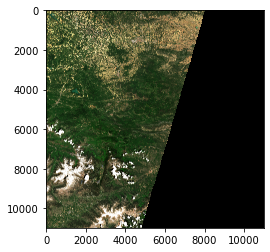

In [12]:
arr_rgb, _, _ = utils.rgb_render(arr, bands=[2,1,0], 
                                 dmin=np.array([0.,0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Read all 10m bands, pixel ROI

In [13]:
arr = dataset.read_bands(sentinel2.Sentinel2.GROUP_10M, 
                         resolution=10, 
                         region=(1000,1000,1200,1200))

In [14]:
arr.shape

(4, 200, 200)

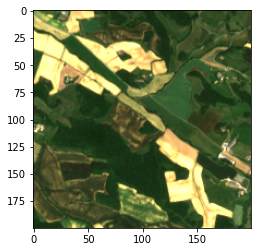

In [15]:
arr_rgb, _, _ = utils.rgb_render(arr, bands=[2,1,0], 
                                 dmin=np.array([0.,0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Read all 10m bands, geographic roi

In [34]:
with rio.open(dataset.build_band_path(sentinel2.Sentinel2.B2)) as ds:
    bounds =ds.bounds
bounds

BoundingBox(left=399960.0, bottom=4690200.0, right=509760.0, top=4800000.0)

In [35]:
sub_bounds = rio.coords.BoundingBox(bounds.left, 
                                    bounds.bottom, 
                                    bounds.left+2000, 
                                    bounds.bottom+2000)

In [36]:
arr = dataset.read_bands(sentinel2.Sentinel2.GROUP_10M, 
                         resolution=10, 
                         region=sub_bounds)

TypeError: unsupported operand type(s) for *: 'Window' and 'int'

In [19]:
arr.shape

(4, 200, 200)

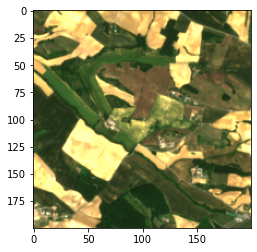

In [20]:
arr_rgb, _, _ = utils.rgb_render(arr, bands=[2,1,0], 
                                 dmin=np.array([0.,0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Read full extent, but in Lambert93

In [21]:
arr = dataset.read_bands(sentinel2.Sentinel2.GROUP_10M, 
                         resolution=10, 
                         crs='epsg:2154')

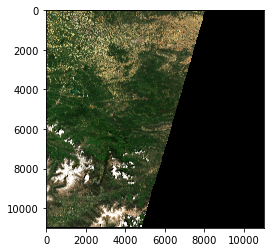

In [22]:
arr_rgb, _, _ = utils.rgb_render(arr, bands=[2,1,0], 
                                 dmin=np.array([0.,0., 0.]), 
                                 dmax=np.array([0.2,0.2,0.2]))
pyplot.imshow(arr_rgb)

## Read 10m and 20m bands, upscale 20m bands at 10m with cubic sampling

In [23]:
arr = dataset.read_bands(sentinel2.Sentinel2.GROUP_10M+sentinel2.Sentinel2.GROUP_20M, 
                         resolution=10, 
                         region=(1000,1000,1200,1200), 
                         algorithm=rio.enums.Resampling.cubic)

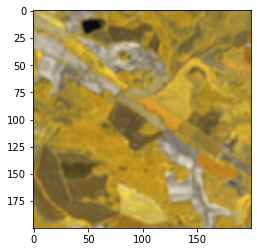

In [24]:
arr_rgb, _, _ = utils.rgb_render(arr, bands=[6,5,4], 
                                 dmin=np.array([0.,0., 0.]), 
                                 dmax=np.array([0.5,0.5,0.5]))
pyplot.imshow(arr_rgb)

## Read bands as an xarray Dataset

In [119]:
arr = dataset.read_bands(sentinel2.Sentinel2.GROUP_10M, 
                         resolution=10, 
                         region=(0,0,200,200), wrap_xarray=True)
arr

<xarray.Dataset>
Dimensions:  (t: 1, x: 200, y: 200)
Coordinates:
  * t        (t) datetime64[ns] 2019-05-31
  * x        (x) float64 4e+05 4e+05 4e+05 ... 4.019e+05 4.019e+05 4.02e+05
  * y        (y) float64 4.8e+06 4.8e+06 4.8e+06 ... 4.798e+06 4.798e+06
Data variables:
    B2       (t, y, x) float32 0.0364 0.0378 0.0406 ... 0.035 0.033 0.0336
    B3       (t, y, x) float32 0.0652 0.068 0.0742 ... 0.0618 0.0622 0.0646
    B4       (t, y, x) float32 0.063 0.0712 0.0735 ... 0.0517 0.0507 0.0528
    B8       (t, y, x) float32 0.2343 0.2349 0.2369 ... 0.2515 0.2528 0.2599
Attributes:
    tile:     31TDH
    crs:      EPSG:32631

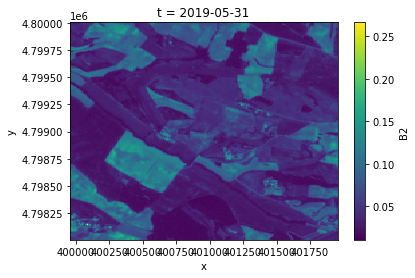

In [123]:
arr['B2'].plot()